In [43]:
from qiskit import *
from qiskit_aer import AerSimulator
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error
#from qiskit_experiments import *
from qiskit.quantum_info import state_fidelity
from qutip import *

#### Definir backend

In [44]:
# Backend com ruído
backend = AerSimulator()

# Criando modelo de ruído (depolarização como exemplo)
noise_model = NoiseModel()

# Erro de 1 qubit (ex: 1% de chance de erro de porta)
error1 = depolarizing_error(0.01, 1)
# Erro de 2 qubits (ex: 2% de chance de erro de porta)
error2 = depolarizing_error(0.01, 2)
error3 = depolarizing_error(0.03, 2)

# Adiciona ruído nas portas comuns
noise_model.add_all_qubit_quantum_error(error1, ['h', 'x', 'z'])
noise_model.add_all_qubit_quantum_error(error2, ['cx'])
noise_model.add_all_qubit_quantum_error(error3, ['swap'])

#### Tomografia

In [45]:
def function_tel_tomography(n=0, shots=1000):
    # Registradores quânticos
    Alice = QuantumRegister(1, 'Alice')
    Bob = QuantumRegister(1, 'Bob')
    Secret = QuantumRegister(1, 'Secret')
    c = ClassicalRegister(3, 'c')  # c[0] = Secret, c[1] = Alice, c[2] = tomografia

    if n > 0:
        ext = QuantumRegister(n, 'ext')
        circuit = QuantumCircuit(Secret, Alice, Bob, ext, c)
    else:
        circuit = QuantumCircuit(Secret, Alice, Bob, c)

    # EPR
    circuit.h(Alice)
    circuit.cx(Alice, Bob)
    circuit.barrier()

    # Swaps
    if n > 0:
        circuit.swap(Bob[0], ext[0])
        for i in range(1, n):
            circuit.swap(ext[i - 1], ext[i])
        final_target = ext[n - 1]
    else:
        final_target = Bob[0]

    # Estado secreto: H|0> = |+>
    circuit.barrier()
    circuit.h(Secret)
    circuit.barrier()

    # Entrelançamento e medições
    circuit.cx(Secret, Alice)
    circuit.h(Secret)
    circuit.barrier()

    circuit.measure(Alice, c[0])
    circuit.measure(Secret, c[1])
    circuit.barrier()

    # Correções condicionais baseadas nas medições
    with circuit.if_test((c[1], 1)):  # Se Alice medir 1, aplicar Z
        circuit.z(final_target)

    with circuit.if_test((c[0], 1)):  # Se Secret medir 1, aplicar X
        circuit.x(final_target)

    # =============== TOMOGRAFIA DIRETA ===============
    pauli_list = [
        np.eye(2),
        np.array([[0.0, 1.0], [1.0, 0.0]]),       # X
        np.array([[0, -1.0j], [1.0j, 0.0]]),      # Y
        np.array([[1.0, 0.0], [0.0, -1.0]])       # Z
    ]
    expectation_values = {}
    all_counts = {}

    for base in ['X', 'Y', 'Z']:
        circ = circuit.copy()

        # Aplica a rotação de base antes da medição
        if base == 'X':
            circ.h(final_target)
        elif base == 'Y':
            circ.sdg(final_target)
            circ.h(final_target)

        # Mede o qubit final no registrador c[2]
        circ.measure(final_target, c[2])

        #Execução
        transpiled = transpile(
        circ,
        backend,
        basis_gates=['swap','h','x','z','cx','measure','sdg'],
        optimization_level=0
        )
        result = backend.run(transpiled, shots=100000, noise_model=noise_model).result()
        counts= result.get_counts()

        # Obtenção dos valores esperados
        p0 = sum(cnt for bits, cnt in counts.items() if bits[0]=='0')
        p1 = sum(cnt for bits, cnt in counts.items() if bits[0]=='1')
        total = p0 + p1 or 1
        expectation_values[base] = (p0 - p1) / total
        all_counts[base] = counts

    # Reconstrução da matriz densidade
    rho = 0.5 * (
        pauli_list[0]
        + expectation_values['X'] * pauli_list[1]
        + expectation_values['Y'] * pauli_list[2]
        + expectation_values['Z'] * pauli_list[3]
    )

    rho_q = Qobj(rho)

    return rho_q, expectation_values, circuit

### Circuito

In [ ]:
rho_4 ,expectation_values_1, circuit_1, counts_1 ,circ= function_tel_tomography(n=4, shots=10000)
print("rho_1 =\n", rho_4)

circ.draw("mpl")

'rho_4 ,expectation_values_1, circuit_1, counts_1 ,circ= function_tel_tomography(n=4, shots=10000)\nprint("rho_1 =\n", rho_4)\n\ncirc.draw("mpl")'

#### Rhos

In [47]:
rho_0 ,expectation_values_0, circuit_0 = function_tel_tomography(n=0, shots=10000)
print("rho_0 =\n", rho_0)

rho_1 ,expectation_values_1, circuit_1 = function_tel_tomography(n=1, shots=10000)
print("rho_1 =\n", rho_1)

rho_2 ,expectation_values_2, circuit_2 = function_tel_tomography(n=2, shots=10000)
print("rho_2 =\n", rho_2)

rho_3 ,expectation_values_3, circuit_3 = function_tel_tomography(n=3, shots=10000)
print("rho_3 =\n", rho_3)

rho_4 ,expectation_values_4, circuit_4 = function_tel_tomography(n=4, shots=10000)
print("rho_4 =\n", rho_4)

rho_5 ,expectation_values_5, circuit_5 = function_tel_tomography(n=5, shots=10000)
print("rho_5 =\n", rho_5)

rho_6 ,expectation_values_6, circuit_6 = function_tel_tomography(n=6, shots=10000)
print("rho_6 =\n", rho_6)

rho_7 ,expectation_values_7, circuit_7= function_tel_tomography(n=7, shots=10000)
print("rho_7 =\n", rho_7)

rho_8 ,expectation_values_8, circuit_8 = function_tel_tomography(n=8, shots=10000)
print("rho_8 =\n", rho_8)

rho_9 ,expectation_values_9, circuit_9 = function_tel_tomography(n=9, shots=10000)
print("rho_9 =\n", rho_9)

rho_10 ,expectation_values_10, circuit_10 = function_tel_tomography(n=10, shots=10000)
print("rho_10 =\n", rho_10)


c:\Users\ianre\miniconda3\envs\cwq\Lib\site-packages\qiskit\compiler\transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


rho_0 =
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.50151+0.j      0.46619+0.00359j]
 [0.46619-0.00359j 0.49849+0.j     ]]
rho_1 =
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.49912+0.j      0.45233-0.00215j]
 [0.45233+0.00215j 0.50088+0.j     ]]
rho_2 =
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.50154+0.j      0.43837+0.00064j]
 [0.43837-0.00064j 0.49846+0.j     ]]
rho_3 =
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.49938+0.j      0.42628-0.00131j]
 [0.42628+0.00131j 0.50062+0.j     ]]
rho_4 =
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.49652+0.j      0.41297+0.00122j]
 [0.41297-0.00122j 0.50348+0.j     ]]
rho_5 =
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Q

#### Obtencao das fidelidades


In [56]:
from qiskit.quantum_info import state_fidelity

rho_ref = Qobj([[0.5,0.5],[0.5,0.5]])

fidelidade_0 = fidelity(rho_0, rho_ref)
print("Fidelidade entre rho_0 e rho_0:", fidelidade_0)

fidelidade_1 = fidelity(rho_1, rho_ref)
print("Fidelidade entre rho_0 e rho_1:", fidelidade_1)

fidelidade_2 = fidelity(rho_2, rho_ref)
print("Fidelidade entre rho_0 e rho_2:", fidelidade_2)

fidelidade_3 = fidelity(rho_3, rho_ref)
print("Fidelidade entre rho_0 e rho_3:", fidelidade_3)

fidelidade_4 = fidelity(rho_4, rho_ref)
print("Fidelidade entre rho_0 e rho_4:", fidelidade_4)

fidelidade_5 = fidelity(rho_5, rho_ref)
print("Fidelidade entre rho_0 e rho_5:", fidelidade_5)

fidelidade_6 = fidelity(rho_6, rho_ref)
print("Fidelidade entre rho_0 e rho_6:", fidelidade_6)

fidelidade_7 = fidelity(rho_7, rho_ref)
print("Fidelidade entre rho_0 e rho_7:", fidelidade_7)

fidelidade_8 = fidelity(rho_8, rho_ref)
print("Fidelidade entre rho_0 e rho_8:", fidelidade_8)

fidelidade_9 = fidelity(rho_9, rho_ref)
print("Fidelidade entre rho_0 e rho_9:", fidelidade_9)

fidelidade_10 = fidelity(rho_10, rho_ref)
print("Fidelidade entre rho_0 e rho_10:", fidelidade_10)


Fidelidade entre rho_0 e rho_0: 0.9829496426572417
Fidelidade entre rho_0 e rho_1: 0.9758739672724135
Fidelidade entre rho_0 e rho_2: 0.9686950037069771
Fidelidade entre rho_0 e rho_3: 0.9624344186181698
Fidelidade entre rho_0 e rho_4: 0.9554946363010102
Fidelidade entre rho_0 e rho_5: 0.9487729022236534
Fidelidade entre rho_0 e rho_6: 0.9416156477365555
Fidelidade entre rho_0 e rho_7: 0.9359647534624272
Fidelidade entre rho_0 e rho_8: 0.930977980405552
Fidelidade entre rho_0 e rho_9: 0.9234500645715646
Fidelidade entre rho_0 e rho_10: 0.9190212290077546


#### Grafico Fidelidade x Swap

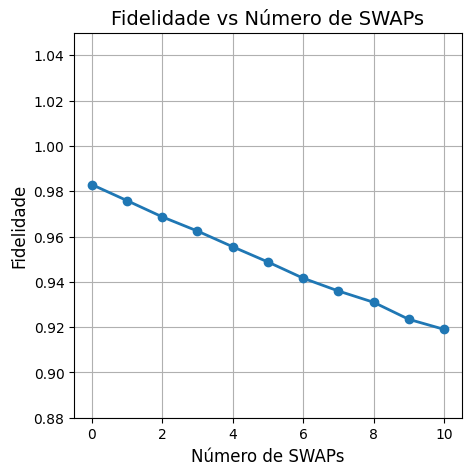

In [57]:
import matplotlib.pyplot as plt

# Colocando os valores já obtidos em uma lista
fidelidades = [
    fidelidade_0,
    fidelidade_1,
    fidelidade_2,
    fidelidade_3,
    fidelidade_4,
    fidelidade_5,
    fidelidade_6,
    fidelidade_7,
    fidelidade_8,
    fidelidade_9,
    fidelidade_10
]

# Criando eixo de swaps (0 a 10)
swaps = list(range(len(fidelidades)))

# Plotando
plt.figure(figsize=(5,5))
plt.plot(swaps, fidelidades, marker='o', linestyle='-', linewidth=2)

plt.title("Fidelidade vs Número de SWAPs", fontsize=14)
plt.xlabel("Número de SWAPs", fontsize=12)
plt.ylabel("Fidelidade", fontsize=12)

# Limitando o eixo y de 0.5 a 1
plt.ylim(0.88, 1.05)

plt.grid(True)
plt.show()




#### Plots

In [52]:
from qutip.entropy import entropy_vn

Entropia_0  = entropy_vn(rho_0, base=2)
print("Entropia_0:", Entropia_0)

Entropia_1  = entropy_vn(rho_1, base=2)
print("Entropia_1:", Entropia_1)

Entropia_2  = entropy_vn(rho_2, base=2)
print("Entropia_2:", Entropia_2)

Entropia_3  = entropy_vn(rho_3, base=2)
print("Entropia_3:", Entropia_3)

Entropia_4  = entropy_vn(rho_4, base=2)
print("Entropia_4:", Entropia_4)

Entropia_5  = entropy_vn(rho_5, base=2)
print("Entropia_5:", Entropia_5)

Entropia_6  = entropy_vn(rho_6, base=2)
print("Entropia_6:", Entropia_6)

Entropia_7  = entropy_vn(rho_7, base=2)
print("Entropia_7:", Entropia_7)

Entropia_8  = entropy_vn(rho_8, base=2)
print("Entropia_8:", Entropia_8)

Entropia_9  = entropy_vn(rho_9, base=2)
print("Entropia_9:", Entropia_9)

Entropia_10 = entropy_vn(rho_10, base=2)
print("Entropia_10:", Entropia_10)


Entropia_0: 0.2130741841280965
Entropia_1: 0.27638982498187725
Entropia_2: 0.3338692510255664
Entropia_3: 0.37964607422911645
Entropia_4: 0.42642203690292196
Entropia_5: 0.4684547601019571
Entropia_6: 0.5099633786397209
Entropia_7: 0.5406609550529312
Entropia_8: 0.5663275847633804
Entropia_9: 0.6028557715732652
Entropia_10: 0.6231817767058419


#### Entropia de Von Neuman

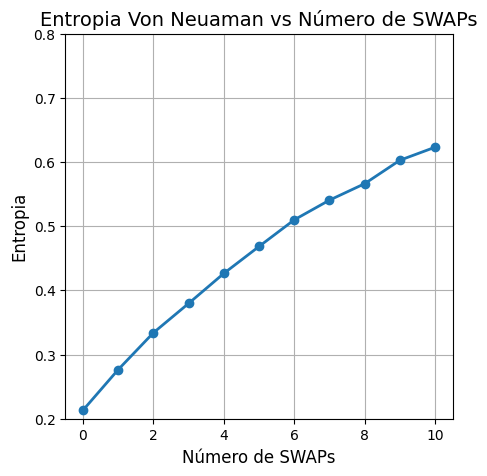

In [59]:
import matplotlib.pyplot as plt

# Colocando os valores já obtidos em uma lista
entropias = [
  Entropia_0,
  Entropia_1,
  Entropia_2,
  Entropia_3,
  Entropia_4,
  Entropia_5,
  Entropia_6,
  Entropia_7,
  Entropia_8,
  Entropia_9,
  Entropia_10
]

# Criando eixo de swaps (0 a 10)
swaps = list(range(len(entropias)))

# Plotando
plt.figure(figsize=(5,5))
plt.plot(swaps, entropias, marker='o', linestyle='-', linewidth=2)

plt.title("Entropia Von Neuaman vs Número de SWAPs", fontsize=14)
plt.xlabel("Número de SWAPs", fontsize=12)
plt.ylabel("Entropia", fontsize=12)

# Limitando o eixo y de 0.5 a 1
plt.ylim(0.20, 0.80)

plt.grid(True)
plt.show()

In [54]:
from qutip import *

# Força bruta: calcular manualmente
distancia_0 = tracedist(rho_ref, rho_0)
print("distancia_0:", distancia_0)

distancia_1 = tracedist(rho_ref, rho_1)
print("distancia_1:", distancia_1)

distancia_2 = tracedist(rho_ref, rho_2)
print("distancia_2:", distancia_2)

distancia_3 = tracedist(rho_ref, rho_3)
print("distancia_3:", distancia_3)

distancia_4 = tracedist(rho_ref, rho_4)
print("distancia_4:", distancia_4)

distancia_5 = tracedist(rho_ref, rho_5)
print("distancia_5:", distancia_5)

distancia_6 = tracedist(rho_ref, rho_6)
print("distancia_6:", distancia_6)

distancia_7 = tracedist(rho_ref, rho_7)
print("distancia_7:", distancia_7)

distancia_8 = tracedist(rho_ref, rho_8)
print("distancia_8:", distancia_8)

distancia_9 = tracedist(rho_ref, rho_9)
print("distancia_9:", distancia_9)

distancia_10 = tracedist(rho_ref,rho_10)
print("distancia_10:", distancia_10)

distancia_0: 0.03403357606834757
distancia_1: 0.04772657331089253
distancia_2: 0.061652559557572324
distancia_3: 0.07373424509683409
distancia_4: 0.0871080920466061
distancia_5: 0.09983216615900906
distancia_6: 0.11336563235831221
distancia_7: 0.12397526769481083
distancia_8: 0.13331858122557413
distancia_9: 0.14727244005583662
distancia_10: 0.15540785726596967


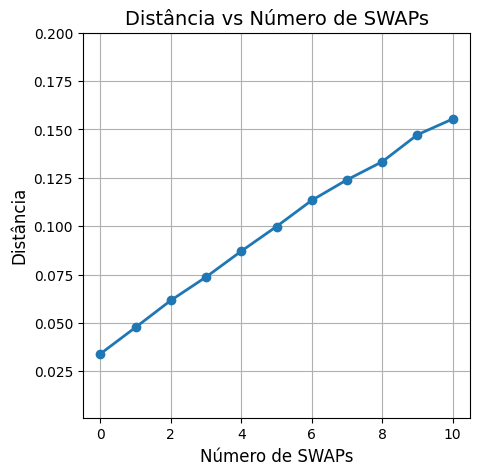

In [55]:
import matplotlib.pyplot as plt

# Colocando os valores já obtidos em uma lista
distancia = [distancia_0,
             distancia_1,
             distancia_2,
             distancia_3,
             distancia_4,
             distancia_5,
             distancia_6,
             distancia_7,
             distancia_8,
             distancia_9,
             distancia_10
]

# Criando eixo de swaps (0 a 10)
swaps = list(range(len(distancia)))

# Plotando
plt.figure(figsize=(5,5))
plt.plot(swaps, distancia, marker='o', linestyle='-', linewidth=2)

plt.title("Distância vs Número de SWAPs", fontsize=14)
plt.xlabel("Número de SWAPs", fontsize=12)
plt.ylabel("Distância", fontsize=12)

# Limitando o eixo y de 0.5 a 1
plt.ylim(0.001, 0.20)

plt.grid(True)
plt.show()